# Correlation Analysis

This notebook examines some correlations

In [1]:
plot_formats = {
    'oxygen' : 'Oxygen ',
    'temperature' : 'Temperature',
    'ph' : 'pH',
    'salinity' : 'Salinity',
    'temperature_optimum' : 'Temperature',
    'ph_optimum' : 'pH',
    'salinity_optimum' : 'Salinity',
    'all_nt_C' : 'G+C Content'
}


In [2]:
import datetime
import json
from glob import glob
import sys 
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.decomposition import PCA
plt.rcParams['svg.fonttype'] = 'none'
plt.style.use('project.mplstyle')

sys.path.append("../")
from genome_spot.helpers import prepend_features, rename_condition_to_variable
from genome_spot.model_training.run_model_selection import BASE_VARS_AAS, BASE_VARS_DERIVED_GENOME, BASE_VARS_DERIVED_PROTEIN, BASE_VARS_PIS, ModelSelection
from genome_spot.taxonomy.taxonomy import TaxonomyGTDB
#from genome_spot.taxonomy.partition import PartitionTaxa
from genome_spot.taxonomy.balance import BalanceTaxa

In [3]:
conditions = ['oxygen', 'temperature', 'salinity', 'ph',  ]
targets = [rename_condition_to_variable(condition) for condition in conditions]

units = {
    'temperature' : u'\N{DEGREE SIGN}C',
    'ph' : 'pH',
    'salinity' : '% w/v NaCl',
    'oxygen' : 'Probability Oxygen Tolerant'
}
units

{'temperature': '°C',
 'ph': 'pH',
 'salinity': '% w/v NaCl',
 'oxygen': 'Probability Oxygen Tolerant'}

In [4]:
feature_sets = ModelSelection().generate_named_feature_sets()
feature_set_dict = dict(feature_sets)
feature_set_dict.keys()

dict_keys(['aas', 'aas_by_compartment', 'aas_diff_compartment', 'pis', 'pis_by_compartment', 'pis_diff_compartment', 'derived', 'derived_by_compartment', 'derived_diff_compartment', 'all', 'all_by_compartment', 'all_diff_compartment'])

In [5]:
all_features = list(set([feat for features in feature_set_dict.values() for feat in features ]))
len(all_features)

174

In [6]:
localizations = ['all', 'intracellular_soluble',  'extracellular_soluble',  'membrane', 'diff_extra_intra']
rename_local = {
    'all' : 'No Localization',
 'extracellular_soluble' : 'Extracellular',
 'intracellular_soluble' : 'Intracellular',
 'membrane' : 'Membrane',
 'diff_extra_intra' : r'$\Delta$ Extra. vs Intra.',
}

In [7]:
rename_base_vars = {
    'nt_C' : 'G+C Content',
    'pur_pyr_transition_freq' : 'R>Y Transitions',
    'protein_coding_density' : 'Coding Density',
    'mean_protein_length' : 'Protein Length',
    'mean_gravy' : 'Hydropathy',
    'mean_nh2o' : 'nH2O',
    'mean_zc' : 'zC',
    'mean_pi' : 'pI',
    'proportion_R_RK' : 'R/R+K',
    'mean_thermostable_freq' : 'Thermostable Residues',
}
rename_base_vars.update({s : s.split('_')[-1] for s in BASE_VARS_AAS})
rename_base_vars.update({s : 'pI ' + '-'.join(s.split('_')[1:]) for s in BASE_VARS_PIS})
rename_base_vars

{'nt_C': 'G+C Content',
 'pur_pyr_transition_freq': 'R>Y Transitions',
 'protein_coding_density': 'Coding Density',
 'mean_protein_length': 'Protein Length',
 'mean_gravy': 'Hydropathy',
 'mean_nh2o': 'nH2O',
 'mean_zc': 'zC',
 'mean_pi': 'pI',
 'proportion_R_RK': 'R/R+K',
 'mean_thermostable_freq': 'Thermostable Residues',
 'aa_A': 'A',
 'aa_C': 'C',
 'aa_D': 'D',
 'aa_E': 'E',
 'aa_F': 'F',
 'aa_G': 'G',
 'aa_H': 'H',
 'aa_I': 'I',
 'aa_K': 'K',
 'aa_L': 'L',
 'aa_M': 'M',
 'aa_N': 'N',
 'aa_P': 'P',
 'aa_Q': 'Q',
 'aa_R': 'R',
 'aa_S': 'S',
 'aa_T': 'T',
 'aa_V': 'V',
 'aa_W': 'W',
 'aa_Y': 'Y',
 'pis_4_5': 'pI 4-5',
 'pis_5_6': 'pI 5-6',
 'pis_6_7': 'pI 6-7',
 'pis_7_8': 'pI 7-8',
 'pis_8_9': 'pI 8-9',
 'pis_9_10': 'pI 9-10',
 'pis_10_11': 'pI 10-11',
 'pis_11_12': 'pI 11-12'}

# Load data

In [8]:
df = pd.read_csv('../data/training_data/training_data.tsv', sep='\t', index_col=0)
all_targets = ['oxygen'] + ['use_salinity', 'use_temperature', 'use_ph',  'ph_max', 'ph_min', 'ph_optimum', 'ph_optimum_max', 'ph_optimum_min', 'salinity_max', 'salinity_midpoint', 'salinity_min', 'salinity_optimum', 'temperature_max', 'temperature_min', 'temperature_optimum', 'aerobe', 'anaerobe', 'microaerophile', 'facultative anaerobe', 'obligate aerobe', 'obligate anaerobe', 'facultative aerobe', 'aerotolerant', 'microaerotolerant']
df_features = df.loc[:, all_features]
df_targets = df.loc[:, all_targets]
df.shape, df_features.shape, df_targets.shape

((15596, 266), (15596, 174), (15596, 25))

In [9]:
for col in ['salinity_optimum', 'temperature_optimum', 'ph_optimum', 'oxygen']:
    print(len(df[~df[col].isnull()]), col, 100*len(df[~df[col].isnull()])/len(df))

2376 salinity_optimum 15.234675557835342
4783 temperature_optimum 30.66812003077712
3549 ph_optimum 22.755834829443447
7300 oxygen 46.80687355732239


In [10]:
df['oxygen'].value_counts()


oxygen
1.0    5604
0.0    1696
Name: count, dtype: int64

In [11]:
for col in ['use_salinity', 'use_temperature', 'use_ph', 'use_oxygen']:
    print(col,len(df[df[col] == True]))

use_salinity 846
use_temperature 2420
use_ph 1022
use_oxygen 7300


In [12]:
from genome_spot.helpers import load_train_and_test_sets, rename_condition_to_variable

PATH_TO_HOLDOUTS = '../data/holdouts/'
#PATH_TO_HOLDOUTS = '../'
for condition in conditions:
    train_set, test_set = load_train_and_test_sets(condition, PATH_TO_HOLDOUTS)
    
    print(len(train_set) + len(test_set), condition, df.loc[train_set + test_set, rename_condition_to_variable(condition)].mean())

3646 oxygen 0.6524958859023587
1722 temperature 33.031087882307396
593 salinity 4.294144209106239
756 ph 7.244411375661375


# Summary Statistics

In [13]:

taxonomy = TaxonomyGTDB()
len(taxonomy.taxonomy_dict.keys())

402709

In [14]:
diversity_rank = 'species'
rank = 'species'
long_set = set(taxonomy.measure_diversity(rank, diversity_rank).keys())#, subset_genomes=one_genome_per_species),
#sorted(long_set)

In [15]:
balancer = BalanceTaxa(taxonomy=taxonomy)
gtdb_species_with_genomes = len(balancer.select_genomes_at_rank(genomes=taxonomy.taxonomy_dict.keys(), rank='species', n_genomes=1))
bacdive_species_with_genomes = len(balancer.select_genomes_at_rank(genomes=df.index.tolist(), rank='species', n_genomes=1))
gtdb_species_with_genomes, bacdive_species_with_genomes

(85205, 12808)

In [16]:
len(df[~df['oxygen'].isnull()])

7300

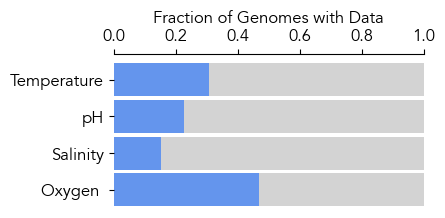

In [17]:
fig, ax = plt.subplots(figsize=(4,2))

bar_data = {}
for target in ['oxygen', 'salinity_optimum',  'ph_optimum','temperature_optimum']:
    nonnull = (~df[target].isnull()).sum()
    null = (df[target].isnull()).sum()
    bar_data[plot_formats[target]] = {'Reported' : (nonnull / (null + nonnull)), 'Not Reported' : (null / (null + nonnull))}
pd.DataFrame(bar_data).T.plot.barh(ax=ax, stacked=True, color=['cornflowerblue', 'lightgray'], legend=False, width=0.9)
#ax.legend(bbox_to_anchor=(0,0), frameon=False)
ax.set_xlabel('Fraction of Genomes with Data')
ax.set_xlim([0,1])
ax.set_ylabel('')
ax.set_ylim([-0.5, 3.7])
ax.xaxis.tick_top()
#to place the tick marks at the top of the image. The command
#ax.set_xlabel('X LABEL')    
ax.xaxis.set_label_position('top') 
ax.spines['left'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['top'].set_visible(True)

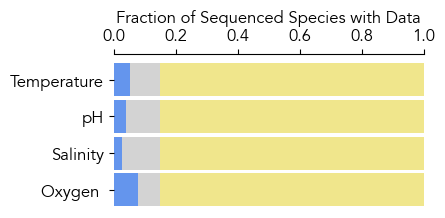

In [18]:


fig, ax = plt.subplots(figsize=(4,2))
bar_data = {}
for target in ['oxygen', 'salinity_optimum',  'ph_optimum','temperature_optimum']:

    nonnull_genomes = df[~df[target].isnull()].index.tolist()
    nonnull_species = len(balancer.select_genomes_at_rank(nonnull_genomes, rank='species', n_genomes=1)) 
    #null_genomes = df[df[target].isnull()].index.tolist()
    #null = (df[target].isnull()).sum()
    bar_data[plot_formats[target]] = {'Reported' : (nonnull_species / gtdb_species_with_genomes), 
                                      'Not Reported' : ((bacdive_species_with_genomes - nonnull_species) / gtdb_species_with_genomes),
                                      'asfsdf' : ((gtdb_species_with_genomes - bacdive_species_with_genomes) / gtdb_species_with_genomes)
                                     }


pd.DataFrame(bar_data).T.plot.barh(ax=ax, stacked=True, color=['cornflowerblue', 'lightgray', 'khaki'], legend=False, width=0.9)
#ax.legend(bbox_to_anchor=(0,0), frameon=False)
ax.set_xlabel('Fraction of Sequenced Species with Data')
ax.set_xlim([0,1])
ax.set_ylabel('')
ax.set_ylim([-0.5, 3.7])
ax.xaxis.tick_top()
#to place the tick marks at the top of the image. The command
#ax.set_xlabel('X LABEL')    
ax.xaxis.set_label_position('top') 
ax.spines['left'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['top'].set_visible(True)

(-2.0, 8.0)

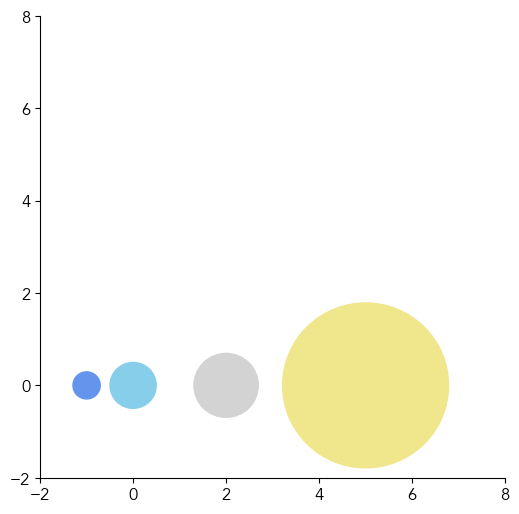

In [19]:
n_all = gtdb_species_with_genomes
n_bacdive = bacdive_species_with_genomes
n_oxygen = len(balancer.select_genomes_at_rank(df[~df['oxygen'].isnull()].index.tolist(), rank='species', n_genomes=1)) 
n_salinity = len(balancer.select_genomes_at_rank(df[~df['salinity_optimum'].isnull()].index.tolist(), rank='species', n_genomes=1)) 

def area_to_radius(n, full_area = 10):
    area_fraction = n / n_all
    area = full_area * area_fraction
    radius = np.sqrt(area / np.pi)
    return radius



circle4 = plt.Circle((-1, 0), area_to_radius(n_salinity, full_area = 10), color='cornflowerblue')
circle1 = plt.Circle((0, 0), area_to_radius(n_oxygen, full_area = 10), color='skyblue')
circle2 = plt.Circle((2, 0), area_to_radius(n_bacdive, full_area = 10), color='lightgray')
circle3 = plt.Circle((5, 0), area_to_radius(n_all, full_area = 10), color='khaki', clip_on=False)

fig, ax = plt.subplots(figsize=(6,6)) # note we must use plt.subplots, not plt.subplot

ax.add_patch(circle1)
ax.add_patch(circle2)
ax.add_patch(circle3)
ax.add_patch(circle4)
lims = [-2,8]
ax.set_xlim(lims)
ax.set_ylim(lims)

In [20]:
pd.DataFrame(bar_data)

,Oxygen,Salinity,pH,Temperature
Reported,0.077636,0.027017,0.040174,0.053295
Not Reported,0.072684,0.123303,0.110146,0.097025
asfsdf,0.849680,0.849680,0.849680,0.849680


oxygen <matplotlib.colors.LinearSegmentedColormap object at 0x2af355d30>
0-0.75    0.232329
>0.75     0.767671
Name: oxygen, dtype: float64
0-0.75    1696
>0.75     5604
Name: oxygen, dtype: int64
oxygen 0.0 1.0
temperature_optimum <matplotlib.colors.LinearSegmentedColormap object at 0x2af398430>
0-15     0.020661
15-30    0.423554
30-45    0.450413
45-60    0.063223
60-80    0.035124
>80      0.007025
Name: temperature_optimum, dtype: float64
0-15       50
15-30    1025
30-45    1090
45-60     153
60-80      85
>80        17
Name: temperature_optimum, dtype: int64
temperature 4.0 105.0
salinity_optimum <matplotlib.colors.LinearSegmentedColormap object at 0x2af398520>
0-1      0.340426
1-2.5    0.167849
2.5-5    0.242317
5-10     0.131206
10-15    0.028369
>15      0.089835
Name: salinity_optimum, dtype: float64
0-1      288
1-2.5    142
2.5-5    205
5-10     111
10-15     24
>15       76
Name: salinity_optimum, dtype: int64
salinity 0.0 27.46821
ph_optimum <matplotlib.colors.LinearSeg

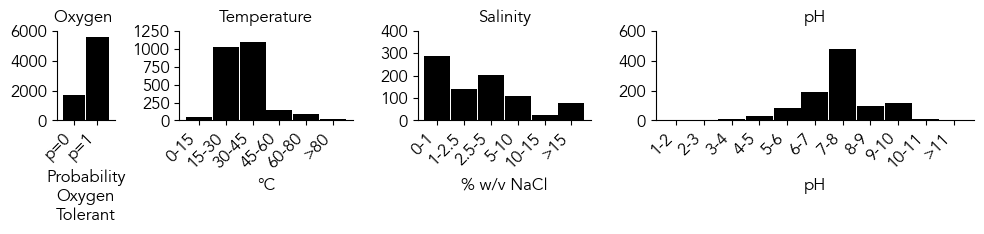

In [21]:
import matplotlib
from collections import Counter
from matplotlib.colors import LinearSegmentedColormap
bin_definitions = {
    'oxygen' : [0, 0.75],
    'ph_optimum' : np.arange(1,12,1),
    'temperature_optimum' : [0,15,30,45,60,80], #np.linspace(0,100,20), #np.percentile(optima_df['temperature'], 100 * np.linspace(0, 1, 100)), 
    'salinity_optimum' : [0, 1, 2.5, 5, 10, 15],
}
oxygen_colors = ['dimgray', 'skyblue']
oxygen_cmap = LinearSegmentedColormap.from_list('my_cmap', oxygen_colors, N=2)
cmap_definitions = {target : plt.get_cmap("RdBu_r") for target in targets}
cmap_definitions['oxygen'] = oxygen_cmap
def colors_by_bin(target, bins, cmap_definitions):
    cmap = cmap_definitions[target]
    colors = [cmap(i/len(bins)) for i in range(len(bins))]
    return colors


# def distribution_df_by_target(target):
#     sers = []
#     bins = bin_definitions[target]
#     for name, group in genome_metadata_df.groupby(['biome1', 'biome2', 'habitat']):
#         for metagenome_id, group in group.groupby('metagenome_id'):
#             genome_ids = group['genome_id'].tolist()
#             binned_ser = histogram_by_values(optima_df, genome_ids, target, bins)
#             binned_ser.name = metagenome_id
#             sers.append(binned_ser)
    
#     n_bins = len(bins) 
#     blank_ser = pd.Series(dict(zip(range(1, n_bins + 1), [0] * n_bins)))
#     blank_ser.name = -1
#     sers.append(blank_ser)
    
#     dist_df = pd.DataFrame(sers).fillna(0).drop(-1)
#     dist_df = (dist_df.T / dist_df.sum(axis=1)).T
#     dist_df = dist_df.T.sort_index().T
#     return dist_df

def histogram_by_values(value_df, genome_ids, target, bins):
    values = value_df.reindex(genome_ids)[target].dropna()
    # hack to fix bad values currently.
    values.loc[values < bins[0]] = bins[0]
    # 
    binned_values = np.digitize(values, bins)
    binned_ser = pd.Series(Counter(binned_values)).reindex(range(1, len(bins) + 1)).fillna(0)
    binned_ser.name = target
    binned_ser.index = [f"{i}-{j}" for i,j in zip(bins, bins[1:])] + [f">{bins[-1]}"]
    return binned_ser

#fig, axes = plt.subplots(2,2,figsize=(5,5))
#fig, axes = plt.subplots(1,4,figsize=(10,2.5))

width_ratios = [len(bin_definitions.get(target)) for target in targets ]

fig, axes = plt.subplots(1,4,figsize=(10,2.5), gridspec_kw={'width_ratios' : width_ratios})
axl = axes.flatten()
for n, condition in enumerate(conditions):
    ax = axl[n]
    
    target = rename_condition_to_variable(condition)
    bins = bin_definitions[target]
    colors = colors_by_bin(target, bins, cmap_definitions)
    subset = df[df[f"use_{condition}"] == True][target].dropna().index
    n_all = len(df[target].dropna())
    n_subset = len(subset)
    ser = histogram_by_values(df, subset, target, bins)
    
    print(target, cmap_definitions[target])
    print(ser / ser.sum())
    ser.plot.bar(ax=ax, width=0.97, color='black')#colors)
    print(ser)
    if target == 'oxygen':
        ax.set_xticklabels(['p=0', 'p=1'], rotation=45, ha='right')
    else:
        xticklabels = [label.get_text() for label in ax.get_xticklabels()]
        ax.set_xticklabels(xticklabels, rotation=45, ha='right')
    xlabel = units[condition]
    
    if len(xlabel) > 25:
        ax.set_xlabel(xlabel.replace(' ', '\n'))
    else:
        ax.set_xlabel(xlabel)
    ax.set_title(plot_formats[target]) # + f"\nn={n_subset} / {n_all}"
    ax.set_yticks(ax.get_yticks())

    #ymin, ymax = ax.get_ylim()
    #ytext = 0.92 * (ymax - ymin) + ymin
    #xtext = 0.95 * (xmax - xmin) + ymin
    #ax.text(s=f'Total={ser.sum()}', x=-0.45, y=ytext, fontsize=10)
    #ax.set_xlim([-0.5,len(ser)-0.45])

    X = df[df[f"use_{condition}"] == True][target]
    print(condition, X.min(), X.max())
plt.tight_layout()

plt.savefig("fig-1b.svg",  format="svg")
plt.show()

In [22]:
sers = []
for condition in conditions:
    target = rename_condition_to_variable(condition)
    sers.append(df[(df[f"use_{condition}"] == True)][target].describe())
pd.concat(sers, axis=1)

,oxygen,temperature_optimum,salinity_optimum,ph_optimum
count,7300.000000,2420.000000,846.000000,1022.000000
mean,0.767671,32.279215,4.015915,7.205479
std,0.422346,11.106102,5.539290,1.324635
min,0.000000,4.000000,0.000000,1.100000
25%,1.000000,27.500000,0.000000,6.750000
50%,1.000000,30.000000,2.250000,7.250000
75%,1.000000,34.125000,4.722500,7.750000
max,1.000000,105.000000,27.468210,12.000000


In [23]:
ax.get_xticklabels()[0].get_text()

'1-2'

In [24]:
target = 'ph'
filter = (df[f'use_{target}'] == True) & (df[f'{target}_optimum'] <= 8) & (df[f'{target}_optimum'] >= 6)
df[filter].shape[0] / df[(df[f'use_{target}'] == True)].shape[0]


0.6771037181996086

In [25]:
filter = (df['use_oxygen'] == True)
len(df[filter & (df['oxygen'] == 1)]) / len(df[filter])

0.7676712328767124

# Correlation of genomic features to growth conditions

In [26]:
heatmap_base_features = BASE_VARS_DERIVED_GENOME + BASE_VARS_DERIVED_PROTEIN + BASE_VARS_PIS + BASE_VARS_AAS
len(heatmap_base_features)

38

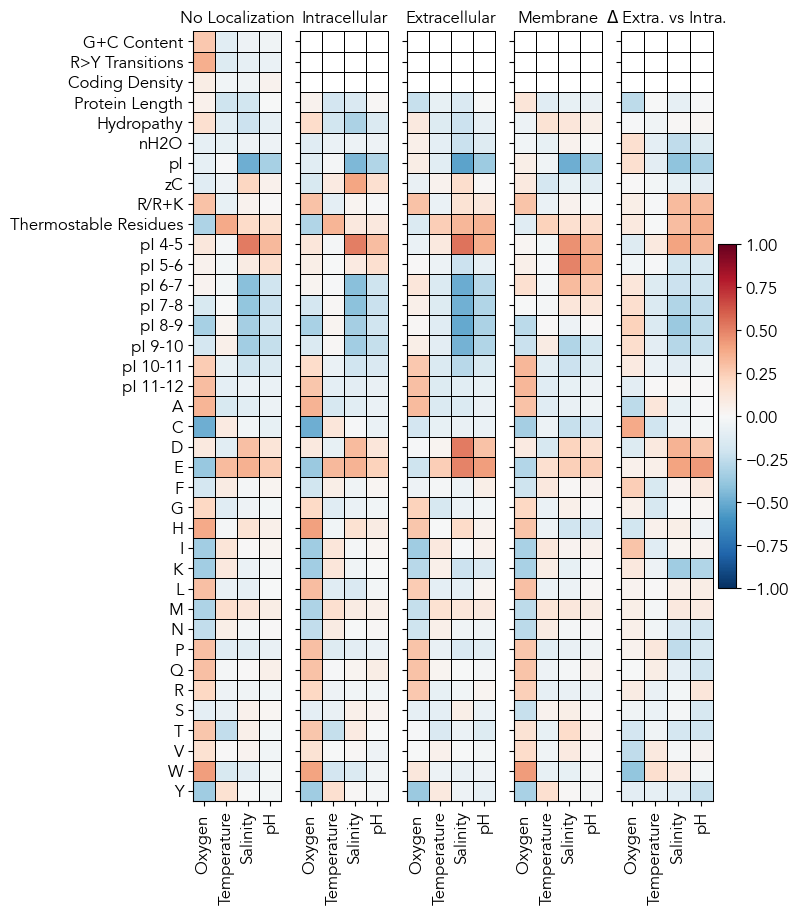

In [27]:

def axes_heatmaps_correlating_by_local(axes):

    for n, localization in enumerate(localizations):
        ax = axes[n]
        
        y_variables = heatmap_features = prepend_features(heatmap_base_features[::-1], [localization])
        x_variables = targets
        y_ticklabels = [rename_base_vars[y] for y in heatmap_base_features[::-1]]
        x_ticklabels = [plot_formats[x] for x in targets]
        
        X = df[x_variables + y_variables]
        method = 'spearman'
        C = X.corr(method=method).T
        c = ax.pcolormesh(range(len(x_variables)), range(len(y_variables)), 
                          C.loc[y_variables, x_variables].values, 
                          cmap='RdBu_r', vmin=-1, vmax=1, edgecolor='black', linewidth=0.5, clip_on=False)
        #ax.set_title(f'{method.capitalize()} Correlation Coefficients of Select Variables\n')
        ax.set_title(rename_local[localization].replace(' - ', ' -\n').replace('y L', 'y\nL'))
        ax.set_xticks(range(len(x_variables)))
        ax.set_yticks(range(len(y_variables)))
        ax.set_xticklabels(x_ticklabels, rotation=90, ha='center')
        
        
        #ax.axis([x.min(), x.max(), y.min(), y.max()])
        
        if n == 0:
            ax.set_yticklabels(y_ticklabels)
        else:
            ax.set_yticklabels([])
            
        if n == len(localizations) - 1:
            fig.colorbar(c, ax=ax,  aspect=20)
    return axes

fig, axes = plt.subplots(1,5,figsize=(7,10), gridspec_kw={'width_ratios' : (1,1,1,1,1.3)})
axes_heatmaps_correlating_by_local(axes)
plt.show()


0 18
0 16
2 17
4 16


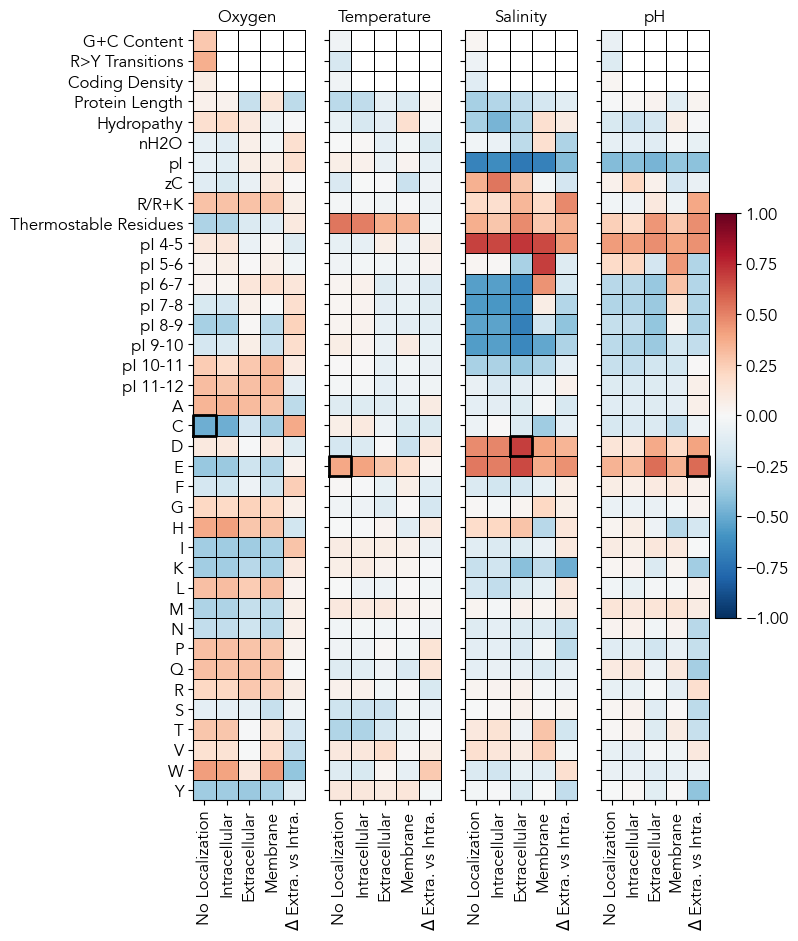

In [28]:
fig, axes = plt.subplots(1,4,figsize=(7,10), gridspec_kw={'width_ratios' : (1,1,1,1.2)})

all_all_features = []
for localization in localizations:
    all_all_features.extend(prepend_features(heatmap_base_features[::-1], [localization]))


highlight_relationships = {
    'temperature_optimum' : ('aa_E', 'all'),
    'ph_optimum' : ('aa_E', 'diff_extra_intra'),
    'salinity_optimum' : ('aa_D', 'extracellular_soluble'),
    'oxygen' : ('aa_C', 'all'),
}

for n, target in enumerate(targets):
    ax = axes[n]

    data = df[df[f"use_{target.replace('_optimum', '')}"] == True]
    X = data[targets + all_all_features]
    method = 'spearman'
    C_all = X.corr(method=method).T

    # grab 1 localization at a time
    C_sers = []
    for localization in localizations:
        ser = C_all.loc[target, prepend_features(heatmap_base_features[::-1], [localization])]
        ser.index = heatmap_base_features[::-1]
        C_sers.append(ser)
    
    C = pd.concat(C_sers, axis=1)
        
    #y_variables = heatmap_features = prepend_features(heatmap_base_features[::-1], [localization])
    x_variables = localizations
    y_ticklabels = [rename_base_vars[y] for y in heatmap_base_features[::-1]]
    x_ticklabels = [rename_local[x] for x in localizations]

    base_var, local = highlight_relationships[target]
    x_box = localizations.index(local)
    y_box = C.index.tolist().index(base_var)
    print(x_box, y_box)
    points = [(x_box-0.5, y_box-0.5), 
             (x_box-0.5, y_box+0.5),
             (x_box+0.5, y_box+0.5),
             (x_box+0.5, y_box-0.5),
             (x_box-0.5, y_box-0.5),
            ]
    ax.plot([tup[0] for tup in points], [tup[1] for tup in points], lw=2, color='black', clip_on=False)
    
    c = ax.pcolormesh(range(len(x_variables)), range(len(y_ticklabels)), 
                      C.values, 
                      cmap='RdBu_r', vmin=-1, vmax=1, edgecolor='black', linewidth=0.5, clip_on=False)
    #ax.set_title(f'{method.capitalize()} Correlation Coefficients of Select Variables\n')
    ax.set_title(plot_formats[target].replace(', Optimum', ''))
    ax.set_xticks(range(len(x_variables)))
    ax.set_yticks(range(len(y_ticklabels)))
    ax.set_xticklabels(x_ticklabels, rotation=90, ha='center')
    #rename_local[localization].replace(' - ', ' -\n').replace('y L', 'y\nL')
    
    #ax.axis([x.min(), x.max(), y.min(), y.max()])
    
    if n == 0:
        ax.set_yticklabels(y_ticklabels)
    else:
        ax.set_yticklabels([])
        
    if n == len(axes) - 1:
        fig.colorbar(c, ax=ax,  aspect=20)

plt.savefig("fig-1c.svg",  format="svg")
plt.show()

temperature_optimum 0.38550672359321014
ph_optimum 0.5632100315026287
salinity_optimum 0.6892760933269817
oxygen -0.490381989963557


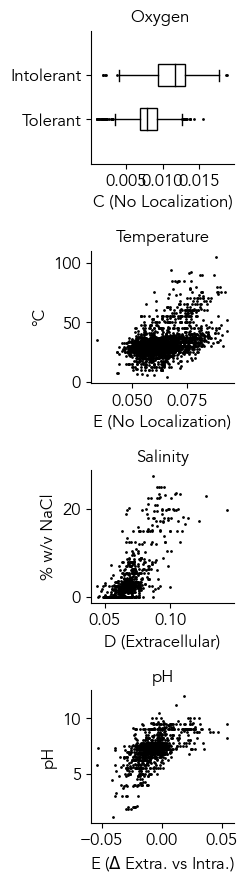

In [30]:
def get_color_by_corr(r):
    cmap = plt.get_cmap("RdBu_r")
    color = cmap((r+1)/2)
    return color
    
def ax_scatter_simple(base_var, local, target, color_by_corr =False):
    condition = target.replace('_optimum', '')
    x = f"{local}_{base_var}"
    data = df[~df[x].isnull() & ~df[target].isnull() & (df[f"use_{condition}"] == True)]
    r = data[[x, target]].corr(method='spearman').iloc[0,1]
    print(target, r)
    
    color ='black'
    if color_by_corr is True:
        color = get_color_by_corr(r)
    ax.scatter(data[x], data[target], s=1, alpha=1, color=color)
    ax.set_xlabel(rename_base_vars[base_var] + f' ({rename_local[local]})')
    ax.set_title(plot_formats[target])
    ax.set_ylabel(units[condition])
    return ax

def normalize_histogram(values, bins, norm = True):  
    digit_to_bin = dict(zip(range(1, len(bins)+1), list(bins) ))    
    binned_values = np.digitize(sorted(values), bins)
    counts = Counter(binned_values)
    if norm is True:
        counts = {k : v / len(binned_values) for k, v in counts.items()}
    binned_ser = pd.Series(counts).sort_index()
    X = binned_ser.index.map(digit_to_bin)
    Y = binned_ser.values
    return X, Y


fig, axes = plt.subplots(4,1, figsize=(2.6,9))
axl = axes.flatten()

ax = axl[1]
base_var, local, target = ('aa_E', 'all', 'temperature_optimum')
ax_scatter_simple(base_var, local, target)

ax = axl[3]
base_var, local, target = ('aa_E', 'diff_extra_intra', 'ph_optimum')
ax_scatter_simple(base_var, local, target)

ax = axl[2]
base_var, local, target = ('aa_D', 'extracellular_soluble', 'salinity_optimum')
ax_scatter_simple(base_var, local, target)

ax = axl[0]
base_var, local, target = ('aa_C', 'all', 'oxygen') 
x = f"{local}_{base_var}"
data = df[df[f"use_{target.replace('_optimum', '')}"] == True]
X_above = data[data[target] > 0.5][x].dropna().values
X_below = data[data[target] < 0.5][x].dropna().values

r = data[[x, target]].corr(method='spearman').iloc[0,1]
print(target, r)
color = get_color_by_corr(r)
color='white'
bins = np.linspace(0.00, 0.023, 46)
bplot = ax.boxplot([X_above,X_below], vert=False, widths=0.5, #colors=color, 
           flierprops={'markersize' : 1, 'color' : 'black'},medianprops={'color' : 'black'},
                   patch_artist=True,
          )
for patch in bplot['boxes']:
    patch.set_facecolor(color)
ax.set_ylim([-0,3])
ax.set_xlabel(x)
ax.set_yticklabels(['Tolerant', 'Intolerant'])
ax.set_title(plot_formats[target])
ax.set_xlabel(rename_base_vars[base_var] + f' ({rename_local[local]})')

plt.tight_layout()
plt.savefig("fig-1d.svg",  format="svg")
plt.show()

# Oxygen
## Simple Thresholds

In [31]:
oxygen_threshold = 0.012
data = df[df['use_oxygen'] == True]
len(data), data[data['all_aa_C'] >oxygen_threshold]['oxygen'].value_counts(), data[data['all_aa_C'] <= oxygen_threshold]['oxygen'].value_counts()

(7300,
 oxygen
 0.0    750
 1.0     76
 Name: count, dtype: int64,
 oxygen
 1.0    5528
 0.0     946
 Name: count, dtype: int64)

0.2970056956696213 1.2314623652955647 -4.146258416085731
0.011
0.07150304622847614
0.686892277673002
0.6153892314445257


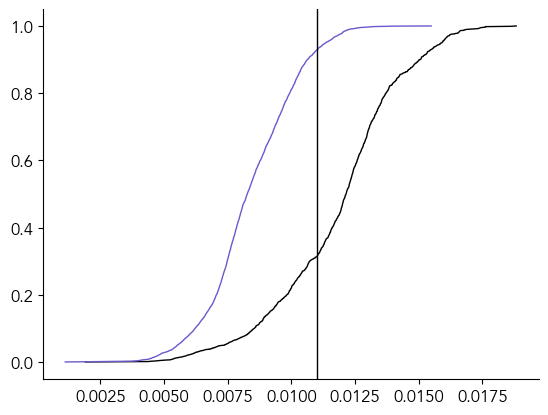

In [42]:
from sklearn.linear_model import LogisticRegression

x = 'all_aa_C'
y = 'oxygen'
data = df[~df[y].isnull()]

X = data[[x]].values
y_train = data[y].values
reg = LogisticRegression(random_state=0).fit(X, y_train)
y_pred = reg.predict(X)
p = 0.5
a = reg.intercept_[0]
b = reg.coef_[0][0]
threshold = (np.log(p/(1-p)) - a) / b
print(threshold, a, b)


X1 = data[data['oxygen'] == 0][x].sort_values().values
X2 = data[data['oxygen'] == 1][x].sort_values().values

C1 = np.cumsum(X1) / np.sum(X1)
C2 = np.cumsum(X2) / np.sum(X2)

for threshold in np.linspace(X1.min(), X1.max(), 100):
    try:
        pass
        #print(np.max(C2[X2 < threshold]) - np.max(C1[X1 < threshold]), threshold, )
    except: 
        pass

threshold = 0.011
fig, ax = plt.subplots()
ax.plot(X1, C1)
ax.plot(X2, C2)
ax.axvline(threshold)

print(threshold)
print(1 - np.max(C2[X2 < threshold]))
print(1 - np.max(C1[X1 < threshold]))
print(np.max(C2[X2 < threshold]) - np.max(C1[X1 < threshold]))

# Feature distributions by localization

In [33]:
variables = derived_features


localization_colors = {'all' : 'black', 'intracellular_soluble' : 'deepskyblue', 'extracellular_soluble' : 'gold', 'membrane' : 'green'}

variables_sans_localization = set()
for var in variables:
    var = var.replace('intracellular_soluble_', '')
    var = var.replace('membrane_', '')
    var = var.replace('extracellular_soluble_', '')
    if var.startswith('all'):
        var = var.replace('all_', '')
    variables_sans_localization.add(var)

fig, axes = plt.subplots(len(variables_sans_localization), 1, figsize=(7, len(variables_sans_localization) * 1))
for n, var in enumerate(sorted(variables_sans_localization)):
    ax = axes[n]
    xmin = 1e10
    xmax = -1e10
    for localization, color in localization_colors.items():
        X = df_features[localization + '_' + var].values

        if np.sum(np.abs(X)) > 0:
            
            ax.hist(X, bins=100, histtype='step', color=color, clip_on=False, density=True)
            
            ax.set_yticks([])
            ax.set_xticks([])
            ax.spines['bottom'].set_visible(False)
            ax.spines['left'].set_visible(False)
            #ax.set_
            if X.min() < xmin:
                xmin = X.min()
            if X.max() > xmax:
                xmax = X.max()
            
    ax.set_ylabel(f'{var}\n{xmin:.2f}-{xmax:.2f}', rotation=0, ha='right')
    #ax.set_xticks([xmin, xmax])
            
plt.tight_layout()

NameError: name 'derived_features' is not defined

# Unsupervised clustering

In [34]:
X = df[select_features]

from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler.fit(X)
X_scaled = scaler.transform(X)

from sklearn.decomposition import PCA
pca = PCA(n_components=2)
pca.fit(X_scaled)
X_pca = pca.transform(X_scaled)
print(pca.explained_variance_)

from sklearn.manifold import TSNE
t_sne = TSNE(
    n_components=2,
    perplexity=20,
    init="random",
    n_iter=250,
    random_state=0,
)

X_tsne = t_sne.fit_transform(X_scaled)
X_tsne.shape

c = 'temperature_optimum'
cmap = 'magma'

fig, axes = plt.subplots(1,2, figsize=(16,8))
size = 5
C = df[c]
ax = axes[0]

X_display = X_pca[~C.isnull()]
ax.scatter(X_display[:, 0], X_display[:, 1], c=np.log2(C[~C.isnull()]), alpha=1,  s=size, cmap=cmap)
ax.set_title(f'PCA of select features (color={c})')

ax = axes[1]
X_display = X_tsne[~C.isnull()]
ax.scatter(X_display[:, 0], X_display[:, 1], c=np.log2(C[~C.isnull()]) , alpha=1, s=size, cmap=cmap)
ax.set_title(f't-SNE of select features (color={c})')

for ax in axes:
    ax.set_xlabel('Dimension 1')
    ax.set_xlabel('Dimension 2')

NameError: name 'select_features' is not defined

In [35]:
# df[df['ncbi_species'].str.contains('Deinococcus radiodurans')]
# df[df['ncbi_species'].str.contains('Synechococcus')]
# df[df['ncbi_species'].str.contains('Corynebacterium glutamicum')]
df[df['ncbi_species'].str.contains('Tepidiforma')]
df[df['ncbi_species'].str.contains('Streptomyces albus')]
df[df['ncbi_species'].str.contains('Mycobacterium')].sort_values('ncbi_taxid')

,all_nt_length,all_pur_pyr_transition_freq,all_nt_C,all_nt_A,all_total_proteins,all_total_protein_length,all_pis_acidic,all_pis_neutral,all_pis_basic,all_pis_3_4,...,facultative aerobe,aerotolerant,microaerotolerant,domain,phylum,class,order,family,genus,species
GCA_000277125,5402404.0,0.538588,0.681008,0.318992,5144.0,1629628.0,0.460342,0.316680,0.222978,0.0,...,NaN,NaN,NaN,Bacteria,Actinomycetota,Actinomycetia,Mycobacteriales,Mycobacteriaceae,Mycobacterium,Mycobacterium intracellulare
GCA_900453675,5313911.0,0.543605,0.694599,0.305401,5077.0,1621693.0,0.524128,0.291708,0.184164,0.0,...,NaN,NaN,NaN,Bacteria,Actinomycetota,Actinomycetia,Mycobacteriales,Mycobacteriaceae,Mycobacterium,Mycobacterium phlei
GCA_001457595,6983269.0,0.546231,0.673289,0.326711,6646.0,2125407.0,0.508878,0.297623,0.193500,0.0,...,NaN,NaN,NaN,Bacteria,Actinomycetota,Actinomycetia,Mycobacteriales,Mycobacteriaceae,Mycobacterium,Mycobacterium smegmatis
GCA_002982335,4352925.0,0.539631,0.655483,0.344517,4077.0,1270175.0,0.354918,0.347069,0.298013,0.0,...,NaN,NaN,NaN,Bacteria,Actinomycetota,Actinomycetia,Mycobacteriales,Mycobacteriaceae,Mycobacterium,Mycobacterium tuberculosis
GCA_002982215,4242175.0,0.539649,0.653420,0.346580,4095.0,1234461.0,0.355800,0.345055,0.299145,0.0,...,NaN,NaN,NaN,Bacteria,Actinomycetota,Actinomycetia,Mycobacteriales,Mycobacteriaceae,Mycobacterium,Mycobacterium tuberculosis
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
GCA_019668465,5831457.0,0.537898,0.670763,0.329237,5460.0,1753430.0,0.480586,0.315568,0.203846,0.0,...,NaN,NaN,NaN,Bacteria,Actinomycetota,Actinomycetia,Mycobacteriales,Mycobacteriaceae,Mycobacterium,Mycobacterium senriense
GCA_001570465,7102084.0,0.532441,0.660156,0.339844,6981.0,2153193.0,0.512391,0.311273,0.176336,0.0,...,NaN,NaN,NaN,Bacteria,Actinomycetota,Actinomycetia,Mycobacteriales,Mycobacteriaceae,Mycobacterium,Mycobacterium fortuitum
GCA_002219285,6133606.0,0.538329,0.677094,0.322906,5683.0,1814250.0,0.429527,0.331691,0.238782,0.0,...,NaN,NaN,NaN,Bacteria,Actinomycetota,Actinomycetia,Mycobacteriales,Mycobacteriaceae,Mycobacterium,Mycobacterium intracellulare
GCA_002219265,6379614.0,0.538054,0.675009,0.324991,5866.0,1871885.0,0.427890,0.331401,0.240709,0.0,...,NaN,NaN,NaN,Bacteria,Actinomycetota,Actinomycetia,Mycobacteriales,Mycobacteriaceae,Mycobacterium,Mycobacterium intracellulare
